## Welcome Paul

This is a notebook made specifi

In [51]:
import re
import torch
import torch.nn as nn
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import soundfile as sf
import librosa
import librosa.display
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, random_split
from copy import deepcopy
from torch import cuda
import copy
from tqdm import tqdm
from torch.optim import AdamW
from codecarbon import track_emissions
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer


# Hardware

Specs of hardware used during training.

```bash
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    11W /  60W |   1310MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1891      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     28468      C   ...lkative_snake/bin/python3     1302MiB |
+-----------------------------------------------------------------------------+
```

Dataloader (SpeechDataset class)

In [2]:
SEED = 42  # defining a seed to facilitate replication
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
def feature_vectors(mel, fs, n_mels):
    mel = mel[:fs]
    S = librosa.feature.melspectrogram(y=mel, sr=fs, n_mels=n_mels)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector
    

In [12]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir, load_method):
        """
        :flac_dir
        """
        self.audio_path_list = sorted(self.find_files(flac_dir)) 
        methods = {"librosa": self.librosa_flac2melspec, "soundfile": self.sf_loader, "torchaudio": self.torch_flac2melspec}
        self.labels = {"es": 0, "en": 1, "de": 2}
        self.languages = {v: k for k, v in self.labels.items()}        
        self.chosen_method = methods[load_method]
        
        
    def __len__(self):
        return len(self.audio_path_list)

    def __getitem__(self, index):
        audio_file = self.audio_path_list[index]  
        label = self.labels[self.get_label(audio_file)]
        spectro, _ = self.chosen_method(audio_file)  # _ is fs        
        #spectro = torch.from_numpy(spectro)
        #spectro = spectro.unsqueeze(0)
        return spectro, label

    def find_files(self, directory, pattern=".flac"):
        """
        Recursive search method to find files. Credit to Paul Magron and Andrea de Marco
        for OG method
        """

        regexFlac = re.compile(rf'/.*fragment\d+\{pattern}$') 
        files = [f.path for f in os.scandir(directory) if regexFlac.search(f.path)]  # ends with does not like regex
        return files
    
    def monolingual_path_list(self, language, gender):
        """
        Input: string ('en'|'de'|'es')
        Output: audio path list only containing file names of the chosen language
        """
        #r = re.compile(rf'.*\/{language}_{gender}.*fragment\d+\.flac') 
        r = re.compile(rf'.*\/{language}.*fragment\d+\.flac') 
        newlist = list(filter(r.match, self.audio_path_list))
        return newlist
    
    def get_label(self, path):
        labelRegex = re.compile(r"(es|en|de)_.*.flac")
        patterns = labelRegex.findall(path)
        assert len(patterns) == 1
        return patterns[0]

    def torch_flac2melspec(self, file_path):
        pass  # commenting option to avoid pip issues on colab
        #waveform, sample_rate = torchaudio.load(file_path, normalize=True)
        #transform = T.MelSpectrogram(sample_rate)        
        #return transform(waveform), sample_rate
        
    def sf_loader(self, file_path):
        with open(file_path, "rb") as f:
            data, samplerate = sf.read(f)
        return data, samplerate

    def librosa_flac2melspec(self, file_path, n_mels=64, melspec_size=512, visual=False):
        """
        the librosa method we are using atm
        """
        sig, fs =  librosa.load(file_path, sr=None)
        sig /= np.max(np.abs(sig), axis=0)
        n_fft = melspec_size
        hop_length = int(n_fft/2)

        # padding signal if less than a second
        if len(sig) < fs:
            padded_array = np.zeros(fs)
            padded_array[:np.shape(sig)[0]] = sig
            sig = padded_array

        melspec = librosa.feature.melspectrogram(y=sig, sr=fs,
                                                 center=True, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)


        if visual:
            self.plotmelspec(melspec, fs, hop_length)

        melspec = librosa.power_to_db(melspec, ref=1.0)
        melspec /= 80.0  # highest db...
        melspec = self.checkmelspec(melspec)        
         
        
        return melspec, fs
    
    
    def checkmelspec(self, melspec, n_mels=64):
        """
        this method works with librosa

        """
        if melspec.shape[1] < n_mels:  # n_mels
            shape = np.shape(melspec)
            padded_array = np.zeros((shape[0], n_mels)) - 1
            padded_array[0:shape[0], :shape[1]] = melspec
            melspec = padded_array
        return melspec

    def plotmelspec(self, melspec, fs, hop_length, show=False):
        plt.figure(figsize=(8, 6))
        plt.xlabel("Time")
        plt.ylabel("Mel-Frequency")
        librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                                 y_axis="mel", fmax=fs/2, sr=fs,
                                 hop_length=hop_length, x_axis="time")
        plt.colorbar(format="%+2.0f db")
        plt.title("Mel Spectogram")
        plt.tight_layout()
        if show:
            plt.show()
        plt.close()  # to close windows and fix warning!

Function to get balanced subset:

In [13]:
def get_balanced_subset(train_data, n, gender):
    '''
    Creates subset with equal amounts of data from each language
    Input: instance of class Speechdataset, desired number of files per language (int) 
    Output: balanced subset (torch.utils.data.dataset.ConcatDataset)
    '''
    #create new instances for each language
    en=deepcopy(train_data)
    es=deepcopy(train_data)
    de=deepcopy(train_data)
    
    
    #modify the audio_path_list to only include paths to files of a single language
    en.audio_path_list=en.monolingual_path_list('en', gender)
    es.audio_path_list=es.monolingual_path_list('es', gender)
    de.audio_path_list=de.monolingual_path_list('de', gender)

    #extract equally sized subsets from each monolingual dataset
    en_sub = Subset(en, torch.arange(n))
    es_sub = Subset(es, torch.arange(n))
    de_sub = Subset(de, torch.arange(n))
    
    subset=en_sub+de_sub+es_sub #concatenate subsets
    return subset

utils.py

In [24]:
# https://debuggercafe.com/saving-and-loading-the-best-model-in-pytorch/

def evaluation(model, val_data, loss_fn):

    device = 'cuda' if cuda.is_available() else 'cpu'

    model.eval()
    with torch.no_grad():
        correct = 0
        loss = 0
        total = 0
        for spectra, labels in val_data:

            spectra = spectra.unsqueeze(1)
            spectra = spectra.to(device)
            labels = labels.to(device)
            preds = model(spectra)
            vals, labels_preds = torch.max(preds.data, 1)  # preds.data == preds? vals are not needed
            total += labels.size(0)  # same as shape[0], what's more pytorch-like?
            correct += (labels_preds == labels).sum().item()
            # loss
            err = loss_fn(preds, labels)
            loss += err.item()
        total_loss = loss / len(val_data)
    return correct / total * 100, total_loss

def visualize(epochs, tr_loss, val_loss, early_stop, save=False):

    fig = plt.figure()
    train, = plt.plot(torch.arange(epochs) + 1, tr_loss, '-og', label="Train")  
    valid, = plt.plot(torch.arange(epochs) + 1, val_loss, '-ob', label="Valid")     
    if early_stop:
        early = plt.axvline(x=early_stop, color = 'r', label = 'Early Stopping', linestyle='dashed') 
        handles = [train, valid, early]
    else:
        handles = [train, valid]
        # https://www.geeksforgeeks.org/plot-a-vertical-line-in-matplotlib/
    plt.xlabel('Epochs')
    plt.ylabel("Loss")    
    plt.legend(handles=handles)
    plt.title('Loss over epochs')
    if save:
        fig.savefig("Loss_over_epochs.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close(fig)

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'model_output/final_speech_cnn.pth')

plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    #def __init__(self, best_valid_loss=float('inf')):
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        #self.path = "./model_output/best_speech_cnn.pth"
        self.path = "model_output/best_speech_cnn.pth"
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion}, self.path)

In [25]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    # https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = Tru

CNNSpeechClassifier Modules

In [26]:
class CNNSpeechClassifier2D(nn.Module):

    def __init__(self, channel_inputs, num_channels1, num_channels2, num_channels3, num_channels4,
                 kernel_size, stride, kernel_pool, stride_pool, padding, num_classes):
        super(CNNSpeechClassifier2D, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(channel_inputs, num_channels1, kernel_size=kernel_size, stride=stride, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels1),
                                        nn.MaxPool2d(kernel_pool, stride=stride_pool))


        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels2),
                                        nn.MaxPool2d(kernel_pool))



        self.cnn_layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels3),
                                        nn.MaxPool2d(kernel_pool))
        
        self.cnn_layer4 = nn.Sequential(nn.Conv2d(64, num_channels4, kernel_size=kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels4),
                                        nn.MaxPool2d(kernel_pool))

        self.dropout = nn.Dropout(0.5)
        self.fc_layer = nn.Linear(num_channels4*2*9, num_classes)  # shape of cnn_layer 2 after convolution of image!

    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = self.cnn_layer3(x)
        x = self.cnn_layer4(x)
        # vectorizing image
        z = x.reshape(x.shape[0], -1)
        z = self.dropout(z)
        return self.fc_layer(z)


train.py

In [27]:
class MyTrainer:

    def __init__(self, model, lr=1e-6):

        self.device = 'cuda' if cuda.is_available() else 'cpu'

        self.total_train_loss = []
        self.total_val_loss = []
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = copy.deepcopy(model)
        self.model.to(self.device)
        self.model.train()
        lr = 1e-3  # 1e-4 best so far?. 1e-3 
        self.optimizer = AdamW(self.model.parameters(), lr=lr)

    #@track_emissions(project_name="spoken_lang_detector", offline=True, country_iso_code='FRA')
    def train_loop(self, train_data, val_data, conv_type='2D', epochs=10, verbose=True, save_local=False, visual=False):

        #https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
        early_stopping = EarlyStopping()
        save_ckp = SaveBestModel()

        early_stop_value = None
        for epoch in tqdm(range(epochs)):
            loss_curr_epoch = 0
            for spectra, labels in train_data:
                self.optimizer.zero_grad()

                if conv_type == '2D':
                    spectra = spectra.unsqueeze(1)

                spectra = spectra.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(spectra)  # 8, 3
                loss = self.loss_fn(preds, labels)
                loss.backward()
                self.optimizer.step()

                loss_curr_epoch += loss.item()

            train_loss = loss_curr_epoch / len(train_data)
            self.total_train_loss.append(train_loss)
            acc, val_loss = evaluation(self.model, val_data, self.loss_fn)
            self.total_val_loss.append(val_loss)
            if verbose:
                self.pretty_print(epoch=epoch, train_loss=train_loss, val_loss=val_loss, acc=acc)
                
            if save_local:
                save_ckp(val_loss, epoch, self.model, self.optimizer, self.loss_fn)
            early_stopping(val_loss)

            if early_stopping.early_stop:
                early_stop_value = epoch+1
                print(f"Early stopping at epoch {early_stop_value}") 
        
        if visual:
            if not early_stop_value:
                early_stop_value = None
            visualize(epochs, self.total_train_loss, self.total_val_loss, early_stop_value)
            
        if save_local:
            save_model(epochs=epochs, model=self.model, optimizer=self.optimizer, criterion=self.loss_fn)
    
    def pretty_print(self, epoch, train_loss, val_loss, acc):
        print(f"Epoch {epoch+1}: train loss is {train_loss:.3f} | val loss is {val_loss:.3f} | Accuracy is {acc:.2f}%")

eval.py

# Data visualization

In [18]:
train_dir = "./Dataset/train/train"
train_dev_data = SpeechDataset(train_dir, "librosa")

train_size = int(len(train_dev_data) * 0.8)
val_size = len(train_dev_data) - train_size

train_data, val_data = random_split(train_dev_data, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True) 
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

# TSNE Embedding

Before training. To complete after deadline

In [131]:
raw_feature_vectors = []
for f in train_dev_data.audio_path_list:
    mel, fs = train_dev_data.librosa_flac2melspec(f)
    y, sr = librosa.load(f)
    raw_feature_vectors.append(feature_vectors(y, sr, n_mels=64))


/tmp/ipykernel_28468/1460995241.py:9: RuntimeWarning: invalid value encountered in divide
  feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)


In [133]:
idx_to_rm = []
for i, feat in enumerate(raw_feature_vectors):    
    if any(np.isnan(feat)):        
        idx_to_rm.append(i)

raw_feature_vectors = [v for i, v in enumerate(raw_feature_vectors) if i not in idx_to_rm] 

In [135]:
raw_tsne_model = TSNE(n_components=3, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(np.array(raw_feature_vectors))

/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2512 samples in 0.001s...
[t-SNE] Computed neighbors for 2512 samples in 0.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2512
[t-SNE] Computed conditional probabilities for sample 2000 / 2512
[t-SNE] Computed conditional probabilities for sample 2512 / 2512
[t-SNE] Mean sigma: 0.089338
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 80.2607193, gradient norm = 0.0135017 (50 iterations in 1.514s)
[t-SNE] Iteration 100: error = 75.9805069, gradient norm = 0.0007891 (50 iterations in 0.868s)
[t-SNE] Iteration 150: error = 75.6678009, gradient norm = 0.0008685 (50 iterations in 1.168s)
[t-SNE] Iteration 200: error = 75.6155548, gradient norm = 0.0000212 (50 iterations in 1.346s)
[t-SNE] Iteration 250: error = 75.6151123, gradient norm = 0.0000075 (50 iterations in 1.360s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.615112
[t-SNE] Iteration 300: erro

# Train

In [28]:
torch.cuda.empty_cache()  # cleaning cache before training

 33%|███████████████                              | 1/3 [00:41<01:23, 41.68s/it]

Epoch 1: train loss is 1.642 | val loss is 0.817 | Accuracy is 61.71%

Best validation loss: 0.8170732202984038

Saving best model for epoch: 1



 67%|██████████████████████████████               | 2/3 [01:16<00:37, 37.76s/it]

Epoch 2: train loss is 0.883 | val loss is 0.685 | Accuracy is 69.84%

Best validation loss: 0.6849340588327438

Saving best model for epoch: 2



100%|█████████████████████████████████████████████| 3/3 [01:54<00:00, 38.04s/it]

Epoch 3: train loss is 0.616 | val loss is 0.465 | Accuracy is 81.15%

Best validation loss: 0.46549113520554136

Saving best model for epoch: 3



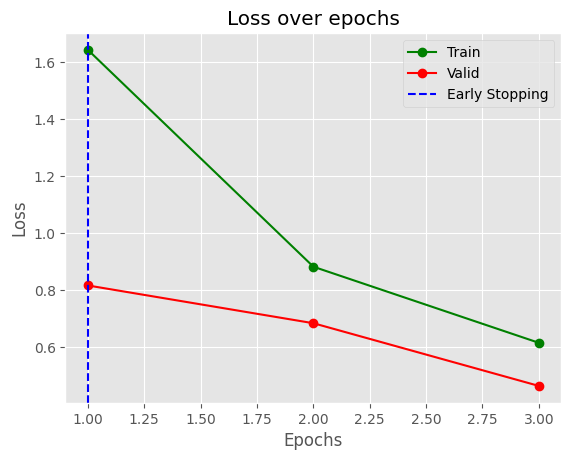

Saving final model...


In [29]:
kernel_size = (3, 3)
stride = (2, 2)
padding = (3, 3)
kernel_pool = 3
stride_pool = 2

CNN_model = CNNSpeechClassifier2D(channel_inputs=1, num_channels1=16,
                                num_channels2=32, num_channels3=64, num_channels4=128,
                                kernel_size=kernel_size, stride=stride,
                                kernel_pool=kernel_pool, stride_pool=stride_pool, padding=padding, num_classes=3)


trainer = MyTrainer(CNN_model)
trainer.train_loop(train_dataloader, val_dataloader, visual=True, save_local=True, epochs=10)

In [29]:
def loss_writer(loss, conv):
    """
    loss: a list containing the validation loss per epoch
    conv: an int corresponding to the number of convolutions used
    returns None. Saves file locally for further analysis
    """
    loss = [str(l) + '\n' for l in loss]
    print(loss)
    with open(str(conv) + 'd_conv-10epochs.txt', 'a') as cnn_writer:
        
        cnn_writer.writelines(loss)
    return None

loss_writer(trainer.total_val_loss, 4)  # UNCOMMENT IF YOU WANT TO STORE THE LOSS FOR VISUALIZATION

def multiconv_visualizer(loss_4, epochs=10):
    fig = plt.figure()
    val_loss_4, = plt.plot(torch.arange(epochs) + 1, loss_4, '-og', label="4 Conv")  
    # val_loss_3, = plt.plot(torch.arange(epochs) + 1, loss_3, '-og', label="3 Conv")  
    # val_loss_2, = plt.plot(torch.arange(epochs) + 1, loss_2, '-og', label="2 Conv")  
    # val_loss_1, = plt.plot(torch.arange(epochs) + 1, loss_1, '-og', label="1 Conv")  
    plt.xlabel('Epochs')
    plt.ylabel("Loss")   
    plt.legend(handles=[val_loss_4])
    plt.title('Loss over epochs')
    plt.show()
    plt.close(fig)
    

['1.085194370103261\n', '0.931522521234694\n', '0.5671202253018107\n', '0.5318256790439287\n', '0.4697302190793885\n', '0.36719356418128996\n', '0.3345277080282805\n', '0.44763120922762606\n', '0.38149566415490377\n', '0.43700182529550696\n']


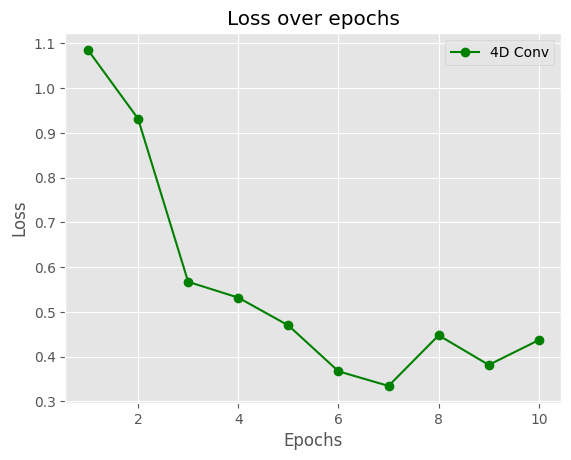

In [30]:
#multiconv_visualizer(trainer.total_val_loss)

# Test

In [15]:
def load_components(checkpoint):


    epoch = checkpoint["epoch"]
    loss_fn = checkpoint["loss"]

    kernel_size = (3, 3)
    stride = (2, 2)
    padding = (3, 3)
    kernel_pool = 3
    stride_pool = 2
    
    model = CNNSpeechClassifier2D(channel_inputs=1, num_channels1=16,
                                num_channels2=32, num_channels3=64, num_channels4=128,
                                kernel_size=kernel_size, stride=stride,
                                kernel_pool=kernel_pool, stride_pool=stride_pool, padding=padding, num_classes=3)
    

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    model.to(device)

    return model, optimizer, epoch, loss_fn



Main

In [16]:
test_dir = "./Dataset/test/test"

test_data = SpeechDataset(test_dir, "librosa")
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)  # one is 4, 64, 862 - 4 despite batch size

best_checkpoint = torch.load("model_output/best_speech_cnn.pth", map_location=device)  # weird form of early stopping. Should add patience
final_checkpoint = torch.load("model_output/final_speech_cnn.pth", map_location=device)
model, optimizer, epoch, loss_fn = load_components(best_checkpoint)

acc, test_loss = evaluation(model, test_dataloader, loss_fn)

print(f"Best epoch {epoch}: Accuracy is {acc:.2f}%")

Best epoch 9: Accuracy is 86.67%


In [46]:
def compute_feature_maps(im, model):  # should be in eval model
    model.eval()
    out_conv1 = model.cnn_layer1(im)        
    out_conv2 = model.cnn_layer2(out_conv1)    
    out_conv3 = model.cnn_layer3(out_conv2) 
    out_conv4 = model.cnn_layer4(out_conv3) 
    feature_maps4 = out_conv4.detach()      
    #print(feature_maps4.shape)  # 128, 2, 9
    return feature_maps4

In [55]:
def gen_f_maps_labels(model, t_dataloader, batch_size=8):
    len_dataset = len(t_dataloader) * batch_size # batch_size
    feature_maps_tot = torch.empty((len_dataset, 128*2*9), dtype=torch.float)  # 128, 2, 9 after convolution spec loses dim
    labels_im_tot = torch.empty(len_dataset, dtype=torch.float)

    with torch.no_grad():
        for ib, (spec, labels) in enumerate(t_dataloader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)  # batch_size
            labels_im_tot[indices_b] = labels.float()
            spec = spec.unsqueeze(1)    
            feature_map = compute_feature_maps(spec, model) 
            in_im_vec = feature_map.reshape(batch_size, -1)  # batch_size         
            feature_maps_tot[indices_b, :] = in_im_vec

    feature_maps_tot = feature_maps_tot.numpy()
    labels_im_tot = labels_im_tot.numpy()
    return feature_maps_tot, labels_im_tot

feature_maps_tot, labels_im_tot = gen_f_maps_labels(CNN_model, train_dataloader)

In [56]:
feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
print('Size TSNE embeddings (input melspectograms):', feature_maps_TSNE.shape)

/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/andres-gon/Documents/LCT-Tasks/UoL/courses/reseaux_de_neurones/spoken_lang/talkative_snake/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Size TSNE embeddings (input images): (2016, 2)


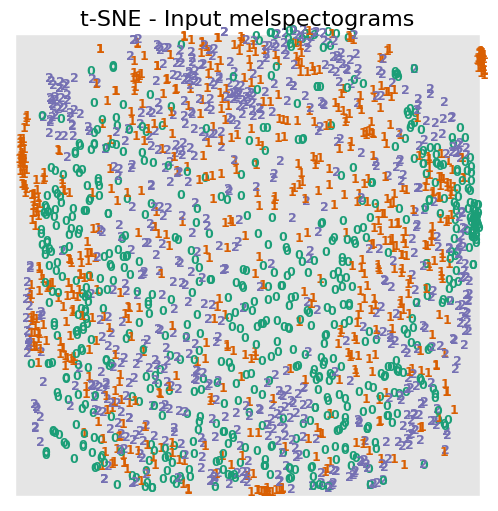

In [57]:
def plot_tsne_embeddings(X, y, title, save=False):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    fig = plt.figure(figsize = (6,6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    if save:
        fig.savefig(f"t-SNE_Input_mels.jpg", bbox_inches="tight", dpi=150)
    plt.show()
    
    return
plot_tsne_embeddings(feature_maps_TSNE, labels_im_tot, 'Input melspectograms')

# Possible improvements

- A cyclic learning rate scheduler instead of early stopping
- Hyperparametrize
- Add weights and biases for logging
- Complete T-SNE visualization embedding before training